<a href="https://colab.research.google.com/github/jagathcharan/Person-name-detection/blob/main/person_name_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Face for Reconization**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install opencv-python numpy

In [ ]:
!pip install opencv-python-headless
!pip install opencv-contrib-python-headless

In [ ]:
from IPython.display import Video, display
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import os

def take_video(filename, duration=30):
    js = Javascript('''
        async function takeVideo(duration) {
            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true, audio: true});

            document.body.appendChild(video);
            video.srcObject = stream;
            await video.play();

            const mediaRecorder = new MediaRecorder(stream);
            const chunks = [];

            mediaRecorder.ondataavailable = function(event) {
                chunks.push(event.data);
            };

            mediaRecorder.onstop = function() {
                const blob = new Blob(chunks, {type: 'video/mp4'});
                const url = URL.createObjectURL(blob);
                const a = document.createElement('a');
                a.href = url;
                a.download = 'video.mp4';
                a.click();
                URL.revokeObjectURL(url);
            };

            // Start recording
            mediaRecorder.start();

            // Stop recording after the specified duration
            setTimeout(() => {
                mediaRecorder.stop();
                stream.getTracks().forEach(track => track.stop()); // Stop all video and audio tracks
                document.body.removeChild(video);
            }, duration * 1200); // Duration in milliseconds

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for the recording to complete and return the video data URL
            return new Promise((resolve) => {
                mediaRecorder.onstop = () => {
                    const blob = new Blob(chunks, {type: 'video/mp4'});
                    const reader = new FileReader();
                    reader.onloadend = () => resolve(reader.result);
                    reader.readAsDataURL(blob);
                };
            });
        }
    ''')
    display(js)
    data = eval_js('takeVideo({})'.format(duration))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

def video_to_images(video_path, folder_path, fps=60):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Check if the video opened successfully
    if not cap.isOpened():
        print("Error opening video file.")
        return

    # Create the folder if it doesn't exist
    os.makedirs(folder_path, exist_ok=True)

    # Frame counter
    frame_count = 0

    # Loop through the video frames
    while cap.isOpened():
        ret, frame = cap.read()

        if ret:
            # Save the frame as an image
            image_path = os.path.join(folder_path, f"frame_{frame_count:04d}.jpg")
            cv2.imwrite(image_path, frame)
            frame_count += 1
        else:
            break

    # Release the video capture object
    cap.release()

    print(f"Extracted {frame_count} frames to {folder_path}")

# Prompt user for filename and append .mp4 suffix if not provided
user_input = input("Enter your name: ")
filename = f"{user_input}.mp4"

try:
    saved_filename = take_video(filename)
    print(f'Saved to {saved_filename}')

    # Show the video that was just recorded.
    display(Video(saved_filename))

    # Extract frames to a folder named after the video file (excluding the .mp4 extension)
    folder_path = f"/content/drive/MyDrive/Face_rec/data/{user_input}"
    video_to_images(saved_filename, folder_path)
except Exception as err:
    # Handle errors related to webcam access or permissions.
    print(f'An error occurred: {str(err)}')

Enter your name: Hemanth


<IPython.core.display.Javascript object>

Saved to Hemanth.mp4


Extracted 536 frames to /content/drive/MyDrive/Face_rec/data/Hemanth


In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

## Annotating

In [ ]:
pip install opencv-python face_recognition numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566164 sha256=d88493e48ade2c7ca16769e06ced119385d10220690466ed2b7c875d62666d52
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [ ]:
pip install opencv-python opencv-python-headless

In [ ]:
import os
import cv2
import numpy as np
import json
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
from keras.models import Model

# Load the pre-trained VGG16 model for feature extraction
base_model = VGG16(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)

def extract_features(face_img):
    img = cv2.resize(face_img, (224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    features = model.predict(img_data)
    return features.flatten()

dataset_path = '/content/drive/MyDrive/Face_rec/data'
features_list = []
labels_list = []

# Dictionary to ensure unique indices
unique_labels = {}
current_index = 0

for folder_name in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder_name)
    if os.path.isdir(folder_path):  # Check if folder_path is a directory
        if folder_name not in unique_labels:
            unique_labels[folder_name] = current_index
            current_index += 1
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path)
            if img is not None:  # Check if the image is loaded correctly
                features = extract_features(img)
                features_list.append(features)
                labels_list.append(unique_labels[folder_name])

features_array = np.array(features_list)
labels_array = np.array(labels_list)

# Save features and labels
np.save('/content/drive/MyDrive/Face_rec/features.npy', features_array)
np.savetxt('/content/drive/MyDrive/Face_rec/labels.txt', labels_array, fmt='%d')

# Save label mapping
with open('/content/drive/MyDrive/Face_rec/label_mapping.json', 'w') as f:
    json.dump(unique_labels, f, indent=4)

# Optionally, print out unique labels to verify
print("Unique labels and their indices:")
for label, index in unique_labels.items():
    print(f'{label}: {index}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━

## Training And Testing

In [ ]:
import numpy as np
import json

# Load features
features = np.load('/content/drive/MyDrive/Face_rec/features.npy')

# Load labels
with open('/content/drive/MyDrive/Face_rec/labels.txt', 'r') as file:
    labels = [line.strip() for line in file.readlines()]

# Load label mapping
with open('/content/drive/MyDrive/Face_rec/label_mapping.json', 'r') as file:
    label_mapping = json.load(file)

# Map labels to integers
label_to_int = {label: idx for idx, label in enumerate(label_mapping.keys())}
int_labels = np.array([label_to_int[label] for label in labels])
num_classes = len(label_mapping)  # Number of classes


In [ ]:
import numpy as np
import json

# Load features
features = np.load('/content/drive/MyDrive/Face_rec/features.npy')

# Load labels
with open('/content/drive/MyDrive/Face_rec/labels.txt', 'r') as file:
    labels = [line.strip() for line in file.readlines()]

# Load label mapping
with open('/content/drive/MyDrive/Face_rec/label_mapping.json', 'r') as file:
    label_mapping = json.load(file)

# Map labels to integers
label_to_int = {label: idx for idx, label in enumerate(label_mapping.keys())}
int_labels = np.array([label_to_int[label] for label in labels])
print(int_labels)
num_classes = len(label_mapping)  # Number of classes


[0 0 0 ... 1 1 1]


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Split data
X_train, X_val, y_train, y_val = train_test_split(features, int_labels, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Example image dimensions
img_height, img_width, img_channels = 64, 64, 3

# Example number of classes
num_classes = 10

# Assuming `features` is your input data with shape (num_samples, img_height * img_width * img_channels)
# You need to reshape it to (num_samples, img_height, img_width, img_channels)
# For example:
# features = features.reshape(-1, img_height, img_width, img_channels)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, img_channels)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,458,186 (9.38 MB)

 Trainable params: 2,458,186 (9.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
img_height, img_width, img_channels = 64, 64, 1
X_train = X_train.reshape(-1, img_height, img_width, img_channels)
X_val = X_val.reshape(-1, img_height, img_width, img_channels)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 62, 62, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,453,506 (9.36 MB)

 Trainable params: 2,453,506 (9.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 392ms/step - accuracy: 0.4822 - loss: 0.7127 - val_accuracy: 0.4800 - val_loss: 0.6968 - learning_rate: 0.0010
Epoch 2/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.5123 - loss: 0.6936 - val_accuracy: 0.5200 - val_loss: 0.6925 - learning_rate: 0.0010
Epoch 3/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5041 - loss: 0.6925 - val_accuracy: 0.4800 - val_loss: 0.6934 - learning_rate: 0.0010
Epoch 4/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4976 - loss: 0.6933 - val_accuracy: 0.5200 - val_loss: 0.6928 - learning_rate: 0.0010
Epoch 5/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5098 - loss: 0.6934 - val_accuracy: 0.5200 - val_loss: 0.6929 - learning_rate: 0.0010
Epoch 6/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4922 - loss: 0.6931 - val_accuracy: 0.5200 - val_loss: 0.6927 - learning_rate: 0.0010
Epoch 7/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4972 - loss: 0.6933 - val_accurac

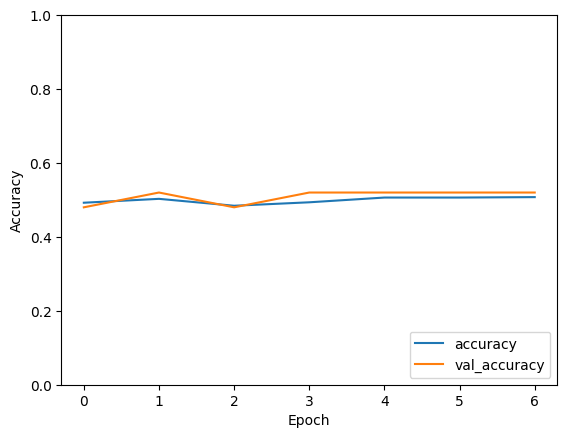

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import numpy as np
import matplotlib.pyplot as plt

# Example dimensions
img_height, img_width, img_channels = 64, 64, 1
num_classes = 2

# Define the model with dropout and additional convolutional layers
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, img_channels)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),  # Dropout layer added
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Dropout layer added
    Dense(num_classes, activation='softmax')
])

# Compile the model with a learning rate scheduler
initial_lr = 0.001
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

# Load and preprocess your data (example placeholders)
X_train = np.random.random((857, img_height, img_width, img_channels))
X_val = np.random.random((100, img_height, img_width, img_channels))
y_train = np.random.randint(0, num_classes, 857)
y_val = np.random.randint(0, num_classes, 100)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=num_classes)
y_val = to_categorical(y_val, num_classes=num_classes)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = LearningRateScheduler(scheduler)

# Fit the model
history = model.fit(
    X_train,
    y_train,
    epochs=25,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, lr_scheduler]
)

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


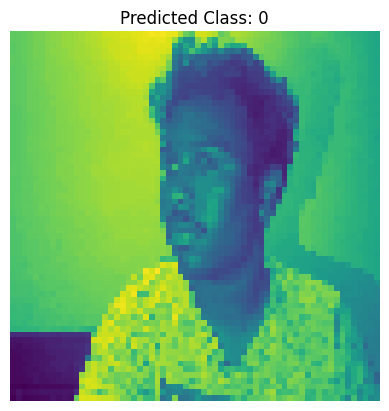

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
# 0 means jagath
# 1 means hemanth
# Example parameters
img_height, img_width = 64, 64  # Same as used during training
num_classes = 2  # Adjust based on your classification task

# Load your trained model (if you saved it)
# model = load_model('path_to_your_model.h5')

# Load and preprocess the image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(img_height, img_width), color_mode='grayscale')
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Normalize to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Example image path
img_path = '/content/drive/MyDrive/Face_rec/data/Jagath/frame_0520.jpg'

# Load and preprocess the image
img_array = load_and_preprocess_image(img_path)

# Make predictions
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions[0])

# Display the result
def display_result(img_path, predicted_class):
    img = image.load_img(img_path, target_size=(img_height, img_width), color_mode='grayscale')
    plt.imshow(img)
    plt.title(f'Predicted Class: {predicted_class}')
    plt.axis('off')
    plt.show()

# Display the result
display_result(img_path, predicted_class)
